<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/attn_is_all_you_need_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notes

We build a Generatively Pretrained Transformer (GPT), following the paper "Attention is All You Need" and OpenAI's GPT-2 / GPT-3. We talk about connections to ChatGPT, which has taken the world by storm. We watch GitHub Copilot, itself a GPT, help us write a GPT (meta :D!) . I recommend people watch the earlier makemore videos to get comfortable with the autoregressive language modeling framework and basics of tensors and PyTorch nn, which we take for granted in this video.

Links:
- Google colab for the video: https://colab.research.google.com/dri...
- GitHub repo for the video: https://github.com/karpathy/ng-video-...
- Playlist of the whole Zero to Hero series so far:    • The spelled-out intro to neural netwo...  
- nanoGPT repo: https://github.com/karpathy/nanoGPT
- my website: https://karpathy.ai
- my twitter:   / karpathy  
- our Discord channel:   / discord  

Supplementary links:
- Attention is All You Need paper: https://arxiv.org/abs/1706.03762
- OpenAI GPT-3 paper: https://arxiv.org/abs/2005.14165
- OpenAI ChatGPT blog post: https://openai.com/blog/chatgpt/
- The GPU I'm training the model on is from Lambda GPU Cloud, I think the best and easiest way to spin up an on-demand GPU instance in the cloud that you can ssh to: https://lambdalabs.com . If you prefer to work in notebooks, I think the easiest path today is Google Colab.

Suggested exercises:
- EX1: The n-dimensional tensor mastery challenge: Combine the `Head` and `MultiHeadAttention` into one class that processes all the heads in parallel, treating the heads as another batch dimension (answer is in nanoGPT).
- EX2: Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? (A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to predict the digits of c in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of train.bin, val.bin. You may want to mask out the loss at the input positions of a+b that just specify the problem using y=-1 in the targets (see CrossEntropyLoss ignore_index). Does your Transformer learn to add? Once you have this, swole doge project: build a calculator clone in GPT, for all of +-*/. Not an easy problem. You may need Chain of Thought traces.)
- EX3: Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?
- EX4: Read some transformer papers and implement one additional feature or change that people seem to use. Does it improve the performance of your GPT?


### 00:00:00 Intro: ChatGPT, Transformers, nanoGPT, Shakespeare  Baseline Language Modeling, Code Setup 00:07:52 Reading and Exploring the Data


In [1]:
# Download the dataset tiny Shakespear Dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-09-22 12:06:35--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  5.17MB/s    in 0.2s    

2024-09-22 12:06:36 (5.17 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
print("Length of dataset in characters: ", len(text))

Length of dataset in characters:  1115394


In [4]:
# looking at the first 1000 chars
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 00:09:28 Tokenization, Train/Val Split


In [5]:
# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
# # expanding the top code
# stoi = {}
# for i,ch in enumerate(chars):
#     stoi[ch] = i
# itos = {}
# for i, ch in enumerate(chars):
#     itos[i] = ch

# def encodetst(s):
#     intlist = []
#     for c in s:
#         intlist.append(stoi[c])
#     return intlist
# def decodetst(l):
#     strlist = []
#     for i in l:
#         strlist.append(itos[i])
#     return "".join(strlist)

# print(encodetst("hii there"))
# print(decodetst(encodetst("hii there")))

In [8]:
# testing tiktoken
!pip install tiktoken

import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")

In [9]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("hii there"))

[71, 4178, 612]


In [10]:
# lets now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [11]:
# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

### 00:14:27 Data Loader: Batches of Chunks of Data


In [12]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [13]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58




1. Setup:
   - Block size = 8 (max context length)
   - Batch size = 4 (parallel sequences)

2. Data Selection:
   - Choose train or val data
   - Think of data as one long string of characters

3. Batch Creation:
   - Pick 4 random starting points in the data
   - For each starting point:
     * Input (X): Take 8 characters
     * Target (Y): Take next 8 characters (offset by 1)

4. Resulting Structure:
   X (inputs):          Y (targets):
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]

5. Training Examples:
   For each row:
     Context    Target
     c          h
     ch         a
     cha        r
     char       3
     ... (up to 8 characters)

6. Key Points:
   - 32 total examples (4 rows * 8 positions)
   - Context grows from 1 to 8 characters
   - Target is always the next character
   - Model learns to predict next char given varying context lengths

This structure allows efficient training on multiple sequences with various context lengths simultaneously.



So, when the lecturer says (B, T, C), they're referring to data with the following structure:
- **Batch**: How many sequences are being processed at once.
- **Time**: How many steps (words/tokens) are in each sequence.
- **Channel**: The number of features representing each word or token (you’ll see this when you use embeddings).



In [14]:
# introducing batch dimension
torch.manual_seed(1337)
batch_size = 4 # how many independent sequence will we process in parallel
block_size = 8 # what is the max context length for prediction

def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print('inputs:')
print(xb.shape)
print(xb)
print('targets')
print(yb.shape)
print(yb)

print('-----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")




inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [15]:
print(xb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


### 00:22:11 Simplest Baseline: Bigram Language Model, Loss, Generation




This code is for a **Bigram Language Model** built using PyTorch. The goal of this model is to predict the next word in a sentence by looking at the current word. Let’s walk through the key elements:

1. **Setting up PyTorch**:
   - We first import PyTorch (`torch`), some neural network modules (`nn`), and set a manual seed to ensure reproducibility.

2. **Defining the Model**:
   - The class `BigramLanguageModel` is created as a type of neural network model (`nn.Module`).
   - Inside the model’s `__init__` function, we initialize an embedding table (`self.token_embedding_table`) that converts words (or tokens) into vectors. This is like a dictionary where each word is assigned a unique vector.
   - `vocab_size` tells the model how many unique words it should consider.

3. **Forward Function**:
   - The `forward` method is where the model does its main work. It takes in two inputs, `idx` (the current word indices) and `targets` (the next word indices, which we want to predict).
   - The `self.token_embedding_table(idx)` converts the word indices (`idx`) into their corresponding vector representations. The result, `logits`, contains information about the likelihood of the next word in the sequence.

4. **Output**:
   - Finally, the model produces an output with a shape that corresponds to the batch size (`B`), the number of tokens in the sequence (`T`), and the number of possible next words (`C`, the vocabulary size).

In simple terms, this model is learning how likely one word is to follow another by directly looking up its prediction from a table. It’s a basic building block for more complex language models.



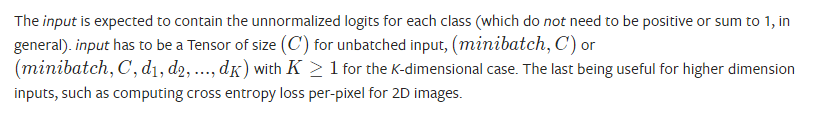

We expect our loss to be less than 4.1743 ie:

```python
import math

result = -math.log(1/65)
print(result)
```

```output
4.174387269895637

```

In [16]:
import math

result = -math.log(1/65)
print(result)


4.174387269895637


In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # tool for converting our x inputs and y targets into vectors

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb) # pass inputs and targets
print(f"vocab_size: ",vocab_size)
print(f"logits.shape: ",logits.shape)
print(f"loss: ",loss)

# idx = torch.zeros((1,1), dtype=torch.long)
# print(decode(m.generate(idx=idx, max_new_tokens=100)[0].tolist()))
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


vocab_size:  65
logits.shape:  torch.Size([32, 65])
loss:  tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


### 00:34:53 Training the Bigram Model


In [18]:
# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [21]:
batch_size = 32
losses = []  # List to store loss values

for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

       # Store the loss value
    losses.append(loss.item())

    # Print loss every 1000 steps
    if steps % 1000 == 0:
        print(f'Step {steps}: Loss {loss.item():.4f}')



Step 0: Loss 2.4184
Step 1000: Loss 2.5300
Step 2000: Loss 2.3797
Step 3000: Loss 2.4651
Step 4000: Loss 2.3533
Step 5000: Loss 2.4624
Step 6000: Loss 2.4510
Step 7000: Loss 2.3258
Step 8000: Loss 2.4357
Step 9000: Loss 2.4936


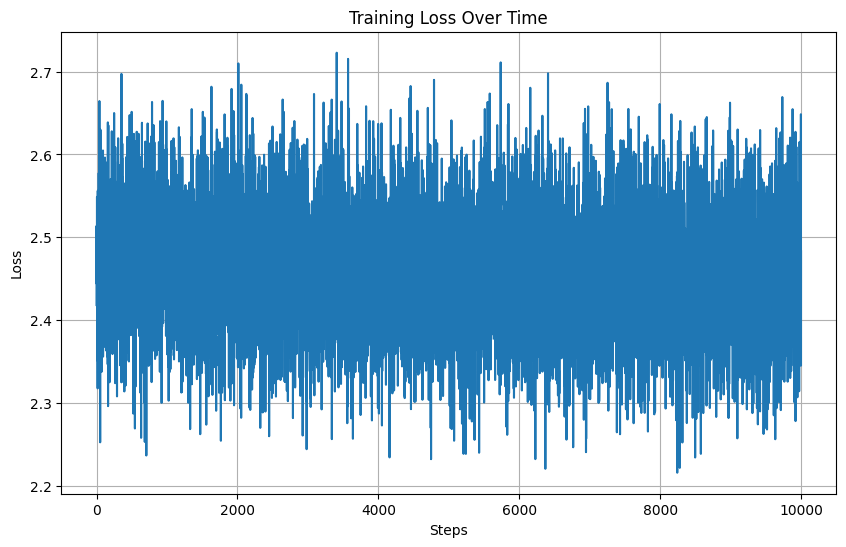

In [22]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [25]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


IUE:

Towe.
Whamo es t, tstt g t RTRushy,
WAsbr spr my ou pl y,
Witoft at o s me,
Whabr'the Cicuomants awonte qungur thme wrar d parsupl by:
'sul ve ave,
Kconit ped bim; fam elathelch easutlll teye A d che'd, met its

IVo wnkn cave!
I thengr ts, IO t
Hoyoolove
ONCENo breppo onder t this r is.
I ckend haiby Lulfaseabot alt mpw thar, d is cthe parn gers b, ace t d t tllined y sss u dst hothin h.
An,

QUThiroligmushielowilit?-f s aishe se achyano OUST:
Juy, wn pr ber,
KE w r wourw. thate ma ore,
TO


### 00:38:00 Porting Our Code to a Script  Building the "Self-Attention"


In [ ]:
%%writefile bigram.py
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data
# define block size
block_size = 8
train_data[:block_size+1]

x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")


# introducing batch dimension
torch.manual_seed(1337)
batch_size = 4 # how many independent sequence will we process in parallel
block_size = 8 # what is the max context length for prediction

def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print('inputs:')
print(xb.shape)
print(xb)
print('targets')
print(yb.shape)
print(yb)

print('-----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # tool for converting our x inputs and y targets into vectors

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb) # pass inputs and targets
print(f"vocab_size: ",vocab_size)
print(f"logits.shape: ",logits.shape)
print(f"loss: ",loss)

# idx = torch.zeros((1,1), dtype=torch.long)
# print(decode(m.generate(idx=idx, max_new_tokens=100)[0].tolist()))
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
losses = []  # List to store loss values

for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

       # Store the loss value
    losses.append(loss.item())

    # Print loss every 1000 steps
    if steps % 1000 == 0:
        print(f'Step {steps}: Loss {loss.item():.4f}')


import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### 00:42:13 Version 1: Averaging Past Context with For Loops, the Weakest Form of Aggregation


### 00:47:11 The Trick in Self-Attention: Matrix Multiply as Weighted Aggregation


### 00:51:54 Version 2: Using Matrix Multiply


### 00:54:42 Version 3: Adding Softmax


### 00:58:26 Minor Code Cleanup


### 01:00:18 Positional Encoding


### 01:02:00 The Crux of the Video: Version 4: Self-Attention


### 01:11:38 Note 1: Attention as Communication


### 01:12:46 Note 2: Attention Has No Notion of Space, Operates Over Sets


### 01:13:40 Note 3: There is No Communication Across Batch Dimension


### 01:14:14 Note 4: Encoder Blocks vs. Decoder Blocks


### 01:15:39 Note 5: Attention vs. Self-Attention vs. Cross-Attention


### 01:16:56 Note 6: "Scaled" Self-Attention. Why Divide by sqrt(Head_Size)


### 01:19:11 Building the Transformer: Inserting a Single Self-Attention Block to Our Network


### 01:21:59 Multi-Headed Self-Attention


### 01:24:25 Feedforward Layers of Transformer Block


### 01:26:48 Residual Connections


### 01:32:51 Layernorm (and Its Relationship to Our Previous Batchnorm)


### 01:37:49 Scaling Up the Model! Creating a Few Variables, Adding Dropout


### 01:42:39 Notes on Transformer: Encoder vs. Decoder vs. Both (?) Transformers


### 01:46:22 Super Quick Walkthrough of nanoGPT, Batched Multi-Headed Self-Attention


### 01:48:53 Back to ChatGPT, GPT-3, Pretraining vs. Finetuning, RLHF


### 01:54:32 Conclusions